In [1]:
"""
Exploring the gravitational N-body problem.
Using so called N-body units: G=M=R=1 
"""
%pylab inline
import time
import math

Populating the interactive namespace from numpy and matplotlib


In [14]:
def acc(r,m,eps):
    a = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            ra2 = ((r[i,:]-r[j,:])**2).sum()
            if (i != j):
                a[i,:] += -(r[i,:]-r[j,:])*m[j]/(ra2**1.5) 
    return a # return acceleration
 
def Jerks(r,v,m,eps):
    Je = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                ra2 = ((r[i,:]-r[j,:])**2).sum() # dot product
                Je[i,:] += - ( (v[i,:]-v[j,:])/ra2**1.5  \
                     - 3.*(((v[i,:]-v[j,:])*(r[i,:]-r[j,:])).sum())/(ra2**2.5) *(r[i,:]-r[j,:]) )* m[j] 
    return Je;
 
def HermiteUpdate(dt, r, v, m):
    a = acc(r, m, 0)          # current acceleration
    adot = Jerks(r,v,m,0)     # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot
    ap = acc(rp,m,0)          # predicted acceleration
    adotp = Jerks(rp,vp,m,0)  # predicted jerks 
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/10 * (ap-a)
 
    return rp,vp
 
def CenterOfMass(r,m):
    CoM = np.zeros(3)
    Mtot= m.sum()
    for i in range(3):
        CoM[i] = (r[:,i]*m).sum()/Mtot
    return CoM
 
def CenterOfMassVelocity(v,m):
    vcom = np.zeros(3)
    Mtot= m.sum()
    for i in range(3):
        vcom[i] = (v[:,i]*m).sum()/Mtot
    return vcom
 
def PotentialEnergy(r,m):
    Phi = np.zeros(len(r))
    for i in range(len(r)):
        for j in range(len(r)):
            ra = np.sqrt(((r[i,:]-r[j,:])**2).sum())
            if (i != j):
                Phi[i] += -m[i]*m[j]/ra 
    return 0.5*Phi.sum()
 
def KineticEnergy(v,m):
    KE = 0.
    for i in range(3): 
        KE += 0.5*(m * (v[:,i]*v[:,i]) ).sum()
    return KE

In [55]:
N=3 # number of bodies
np.random.seed(5) # seed the random generator. This makes sure we get the same sequence everytime
m = np.ones(N)/N
m[0]=1.
m[1]=1e-1
m[2] = 0. # for a moment neglect 3rd body
r = np.random.random((N,3)) # associated positions
r -= CenterOfMass(r,m)
v = -np.random.random((N,3))*2 # associated velocities
v = v - CenterOfMassVelocity(v,m) # CoM does not move
r[:,2] = 0. # keep them in x and y plane
v[:,2] = 0. # also vz=0
print("Initial positions:", r)
print("Initial velocities:", v)
 
tfinal = 1.5
Nsteps = 880
r_res = np.zeros((N,3,Nsteps))
v_res = np.zeros((N,3,Nsteps))
 
dt = tfinal/(Nsteps-1)  # fixed time steps
time = np.zeros(Nsteps)
r_res[:,:,0] = r.copy()
v_res[:,:,0] = v.copy()
Phi= np.zeros(Nsteps)
KE = np.zeros(Nsteps)
Phi[0] = PotentialEnergy(r,m)
KE[0]  = KineticEnergy(v,m)
for i in range(1,Nsteps):
    (r_res[:,:,i],v_res[:,:,i]) = HermiteUpdate(dt, r_res[:,:,i-1], v_res[:,:,i-1], m)
    time[i] = time[i-1] + dt
    Phi[i] = PotentialEnergy(r_res[:,:,i],m)
    KE[i]  = KineticEnergy(v_res[:,:,i],m)
 

Initial positions: [[-0.06332889  0.03475647  0.        ]
 [ 0.63328885 -0.34756465  0.        ]
 [ 0.4805858  -0.31755785  0.        ]]
Initial velocities: [[ 0.04610691  0.01410338  0.        ]
 [-0.46106908 -0.14103382  0.        ]
 [-0.12662356 -0.65288412  0.        ]]


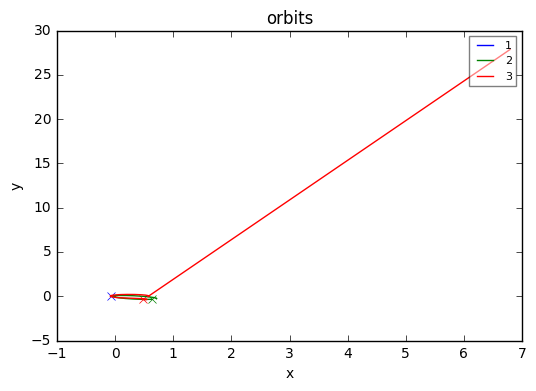

In [56]:
plt.plot(r_res[0,0,0],r_res[0,1,0], 'bx')
plt.plot(r_res[1,0,0],r_res[1,1,0], 'gx')
plt.plot(r_res[2,0,0],r_res[2,1,0], 'rx')
plt.plot(r_res[0,0,:],r_res[0,1,:], 'b-', label="1")
plt.plot(r_res[1,0,:],r_res[1,1,:], 'g-', label="2")
plt.plot(r_res[2,0,:],r_res[2,1,:], 'r-', label="3")
#plt.plot(r_res[3,0,:],r_res[3,1,:], '-', label="4")
#plt.plot(r_res[4,0,:],r_res[4,1,:], '-', label="5")
plt.legend(framealpha=.5,prop={'size':8})
plt.xlabel('x')
plt.ylabel('y')
plt.title('orbits');

In [36]:
m

array([ 1.        ,  0.1       ,  0.33333333])

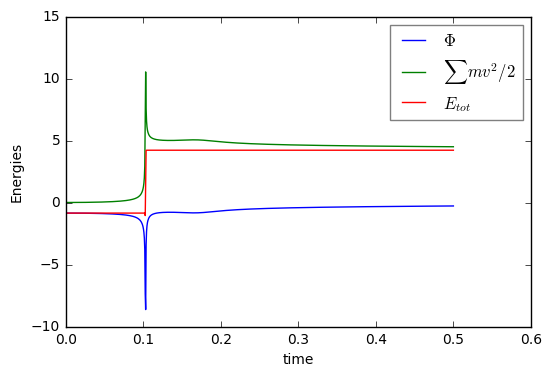

In [50]:
plt.plot(time, Phi, '-',label="$\Phi$")
plt.plot(time, KE, '-',label="$\sum m v^2/2$")
plt.plot(time, KE+Phi, '-', label='$E_{tot}$')

plt.legend(framealpha=0.5)
#plt.legend('lower right',prop={'size':10});
plt.xlabel('time');
plt.ylabel('Energies');

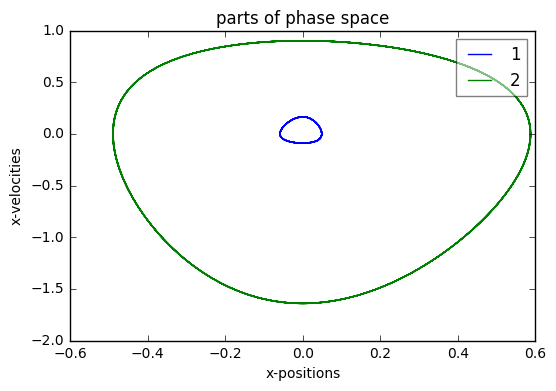

In [23]:
ax = 0
axis = ('x','y','z')[ax]
plt.plot(r_res[0,ax,:],v_res[0,ax,:], '-',label="1")
plt.plot(r_res[1,ax,:],v_res[1,ax,:], '-', label="2")

plt.legend(framealpha=.5)
plt.xlabel(axis+'-positions')
plt.ylabel(axis+'-velocities')
plt.title('parts of phase space');
 

# Ideas to go from here:
 
* Leap-Frog Integrator
* Euler Integrator
* Fix Potential Computation to not double count the pairs (getting rid of the 0.5 at the end)
* Adaptive Time Step Size Control

* Create Interesting Initial Conditions. 
    * Star falling towards a tight binary system. 
    * Planet orbiting star being perturbed by a larger planet 
    * Complex many body systems with N ~ 10
    * Model our solar system and study long term stability